In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
os.chdir("/Users/bytedance/MLTrader-Research/")
import sys
sys.path.insert(0, ".")
import research.orderbook_strategies.utils.helper as helper
import research.orderbook_strategies.utils.factor_analysis as factor_analysis
import research.orderbook_strategies.utils.factors as factors
from research.orderbook_strategies.utils.product_info import product_info
import itertools
import pandas as pd
from collections import OrderedDict
import functools
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask
from dask import compute, delayed
warnings.filterwarnings('ignore')
import scipy
from scipy.stats import norm
import seaborn as sns
product_list = ["OPUSDT","BTCUSDT", "ETHUSDT", "APTUSDT", "1000PEPEUSDT"]
ATR_FILTER = 0.02
MAX_SPREAD_RATIO = 1.1

factor = factors.foctor_ma_diff_period()
# 脚本现在开始
periods = factor.params["period"]
signal_name_format = factor.factor_name

In [3]:

# %%time
# 构造因子
for product in product_list:
    file_list = helper.get_file_list(product)
    helper.parLapply(file_list, 
                        factor_analysis.build_composite_signal,
                        signal_list=[factor], 
                        product=product,
                        overwrite=True,)

In [5]:
all_product_signal_periods = {}
for period in periods:
    signal_name = signal_name_format.format(period=period)
    all_product_signal_periods[period] = helper.get_signal_data(product_list, signal_name)
    
tick_ret = helper.get_field_data(product_list, "ret")

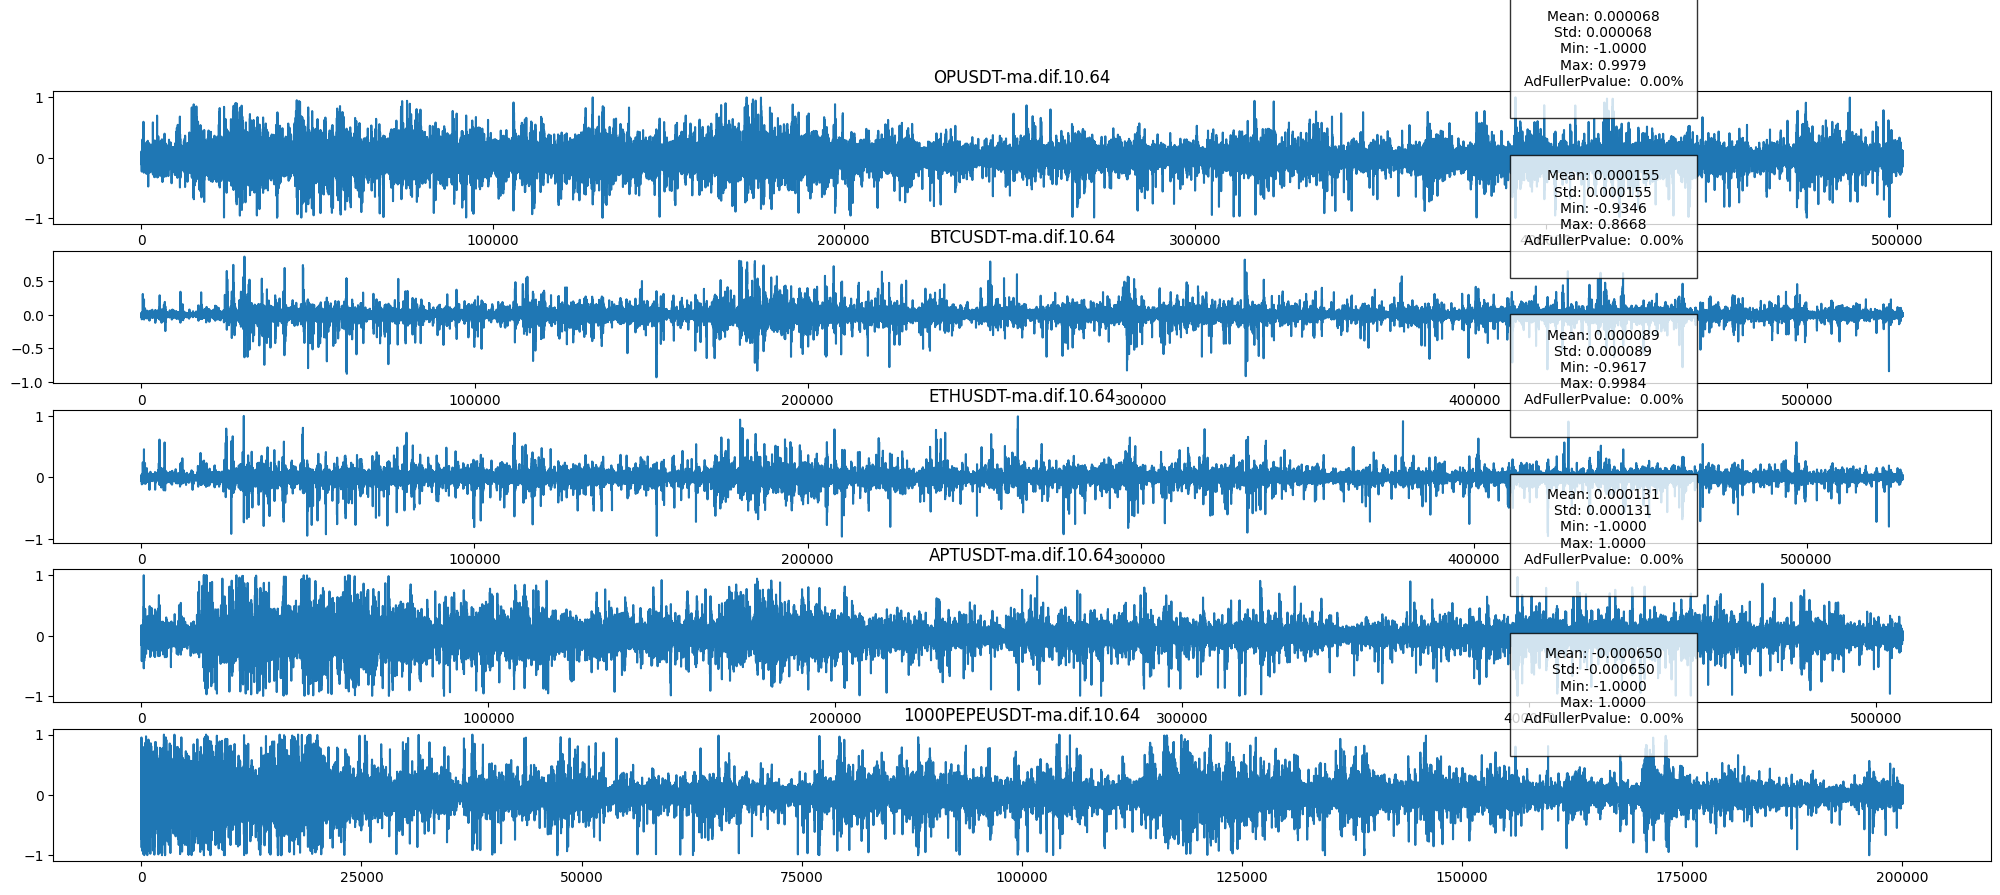

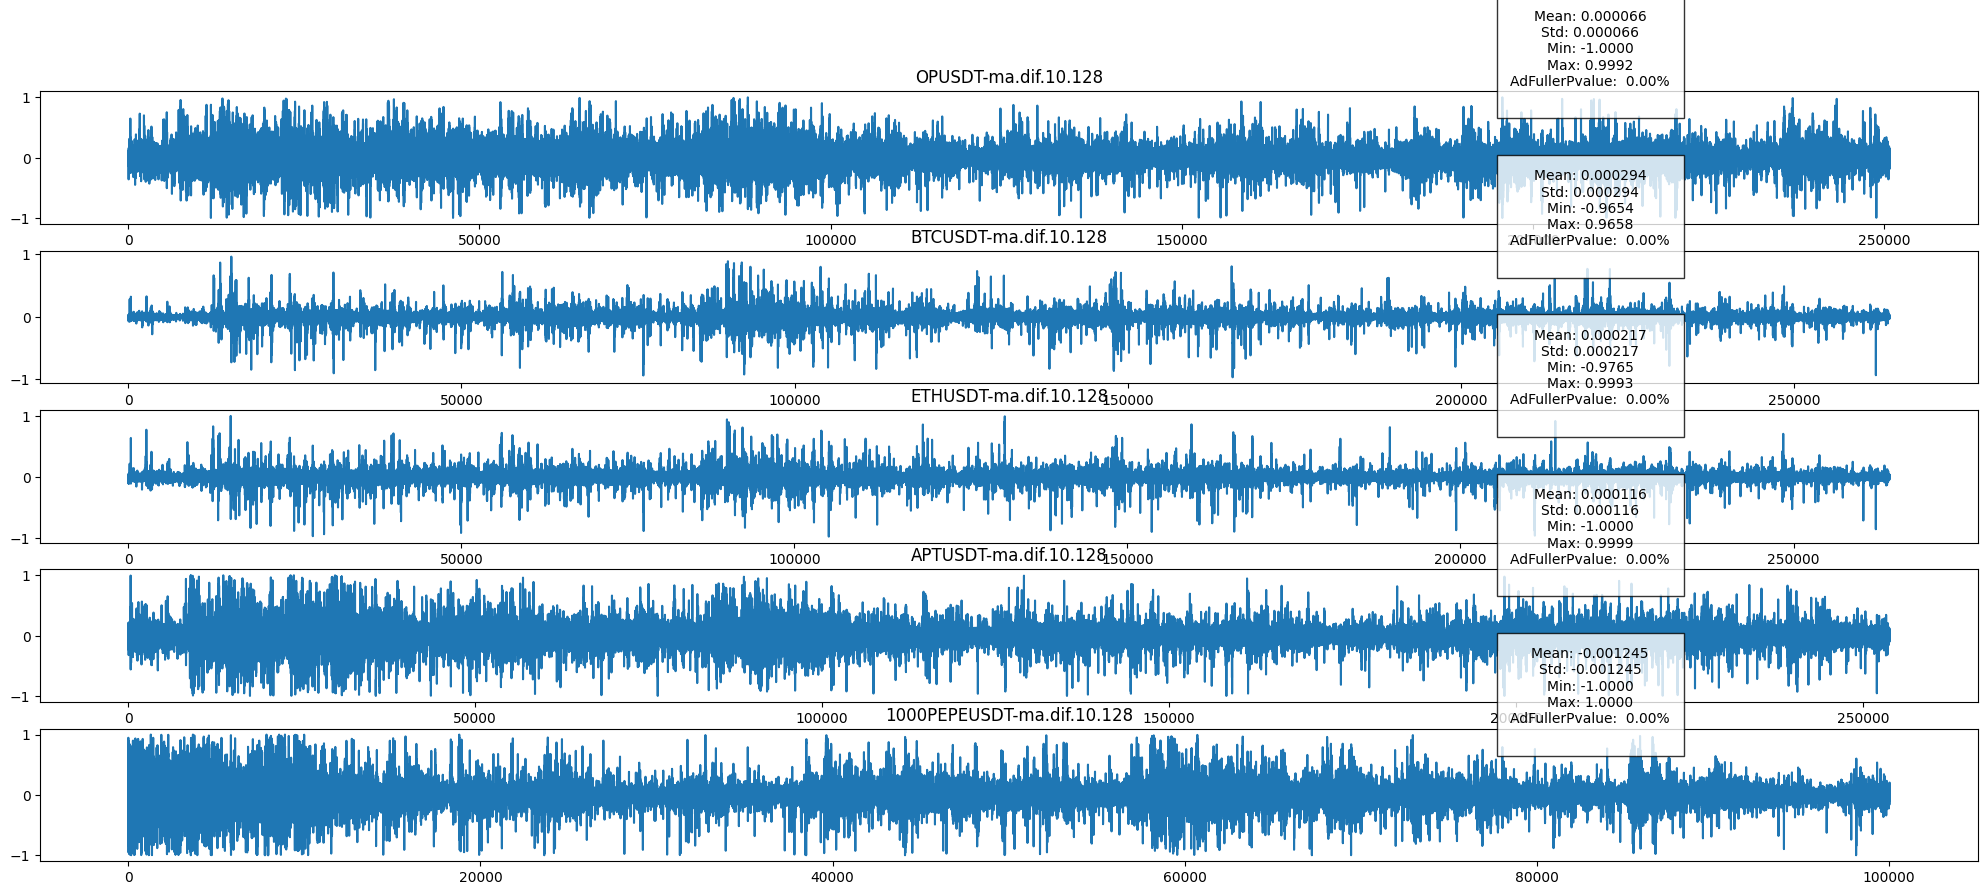

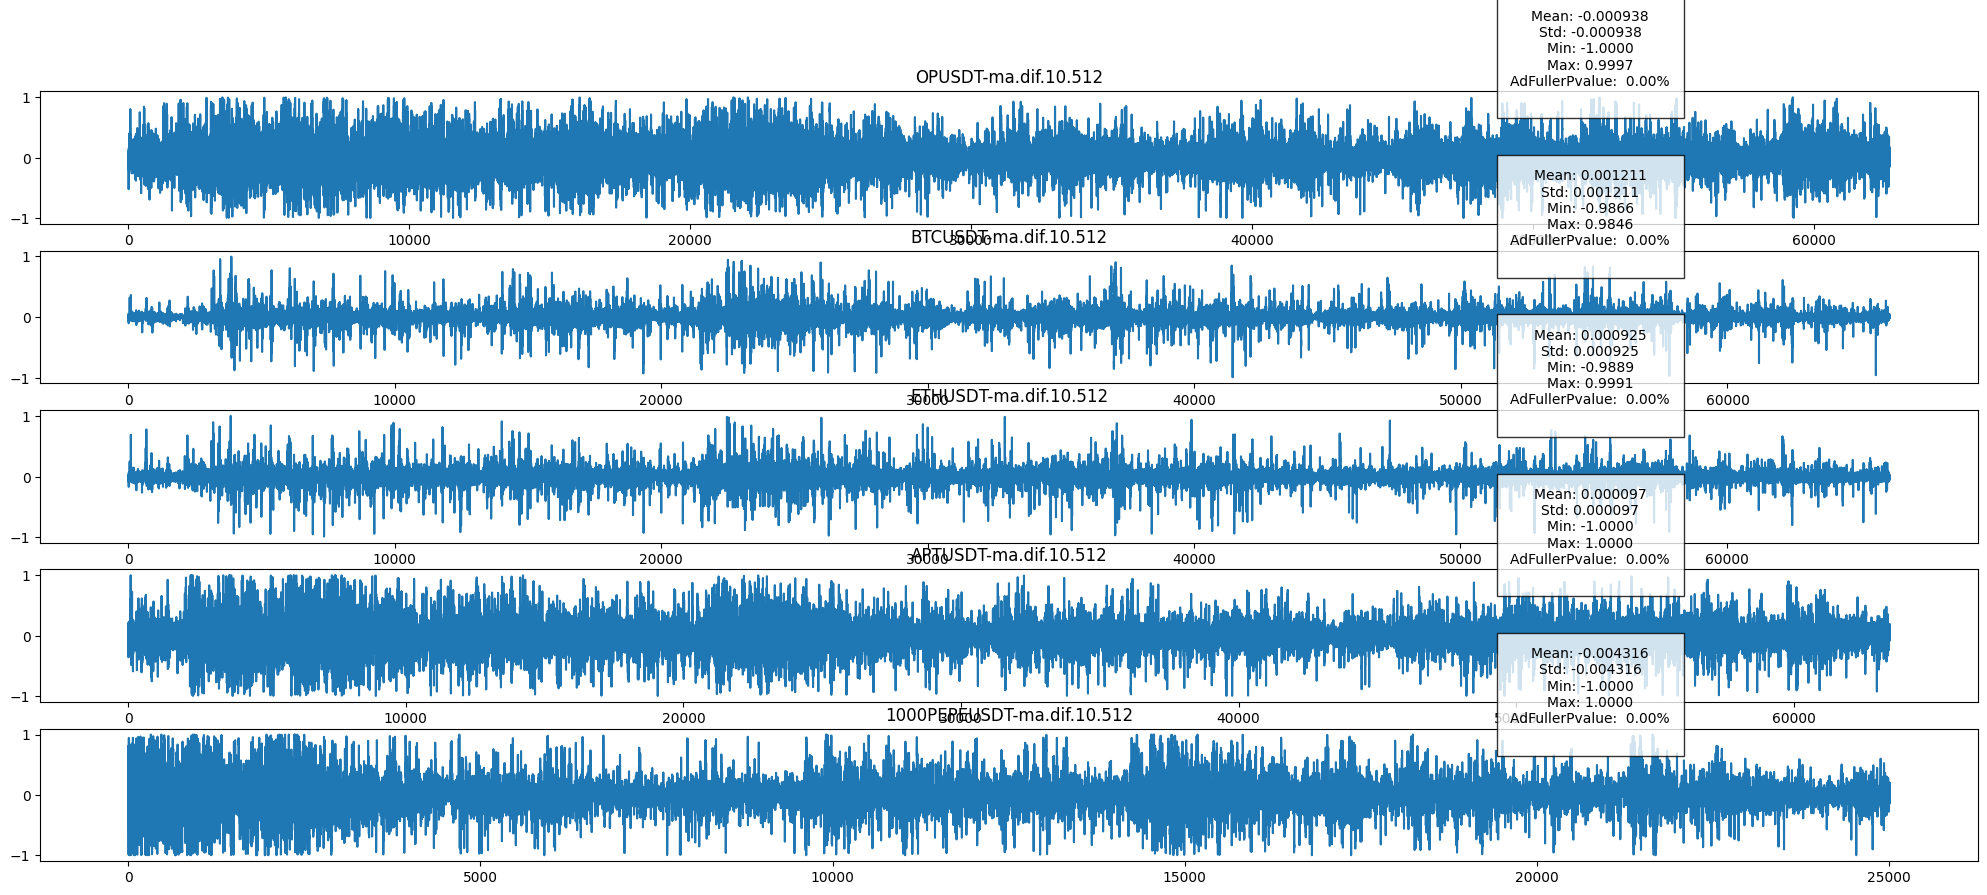

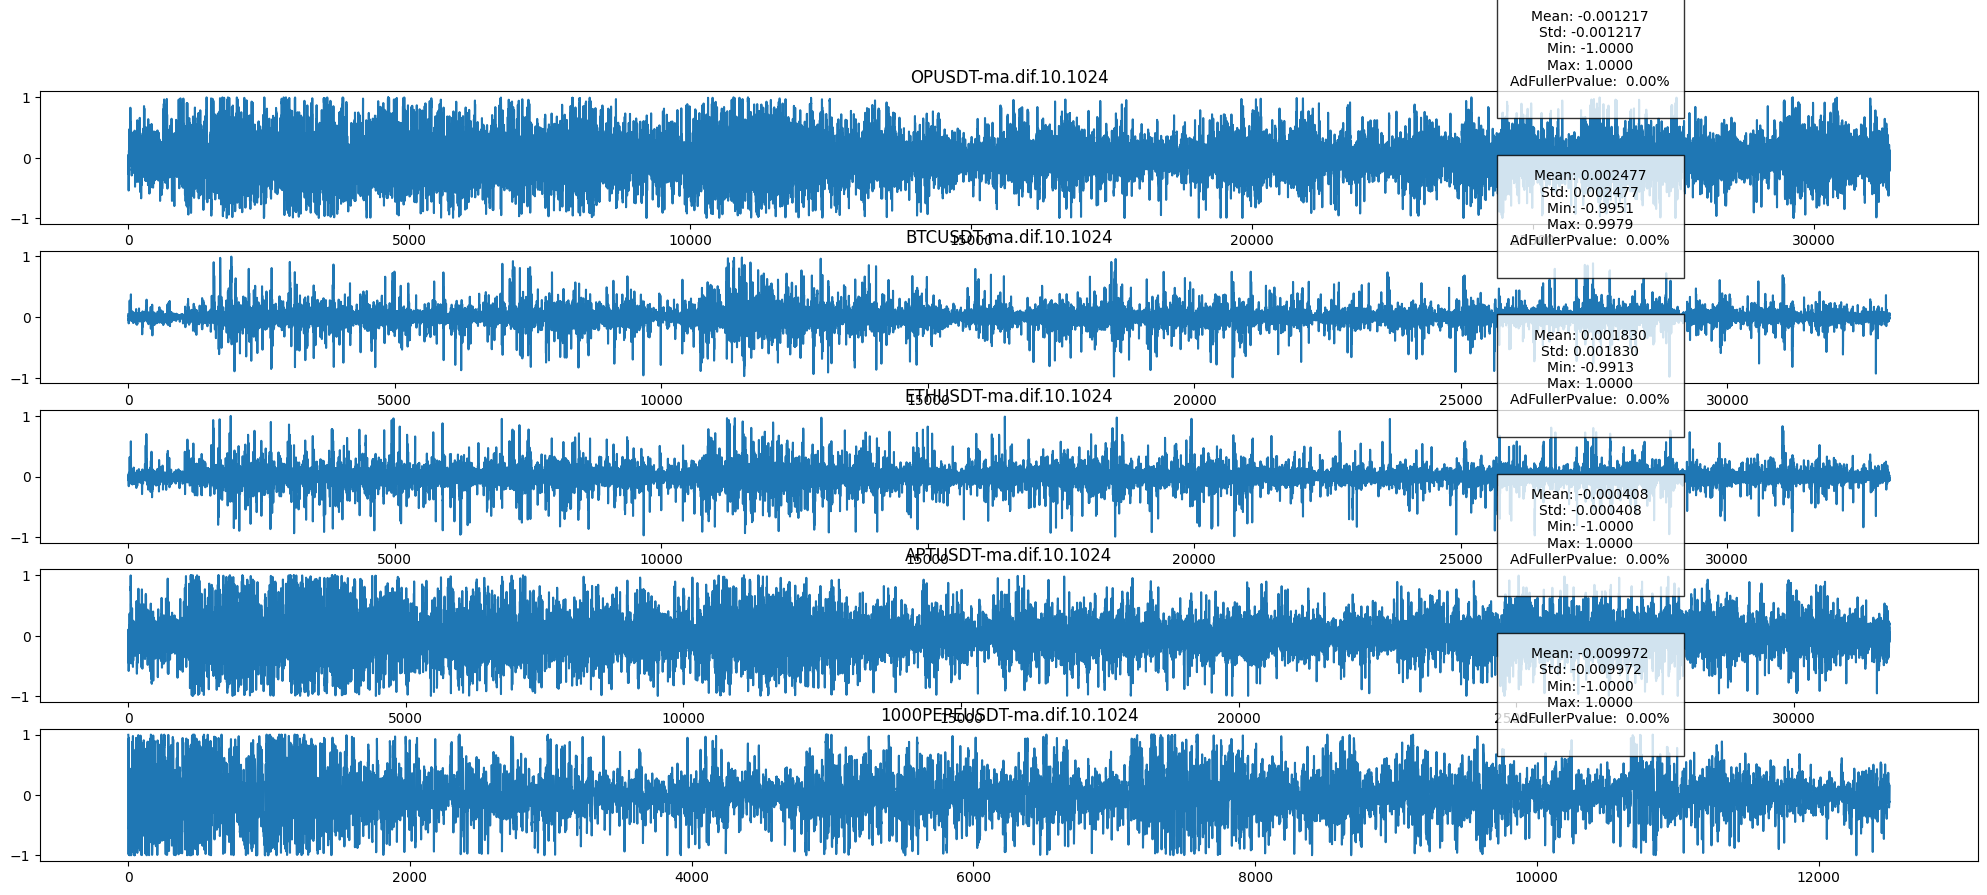

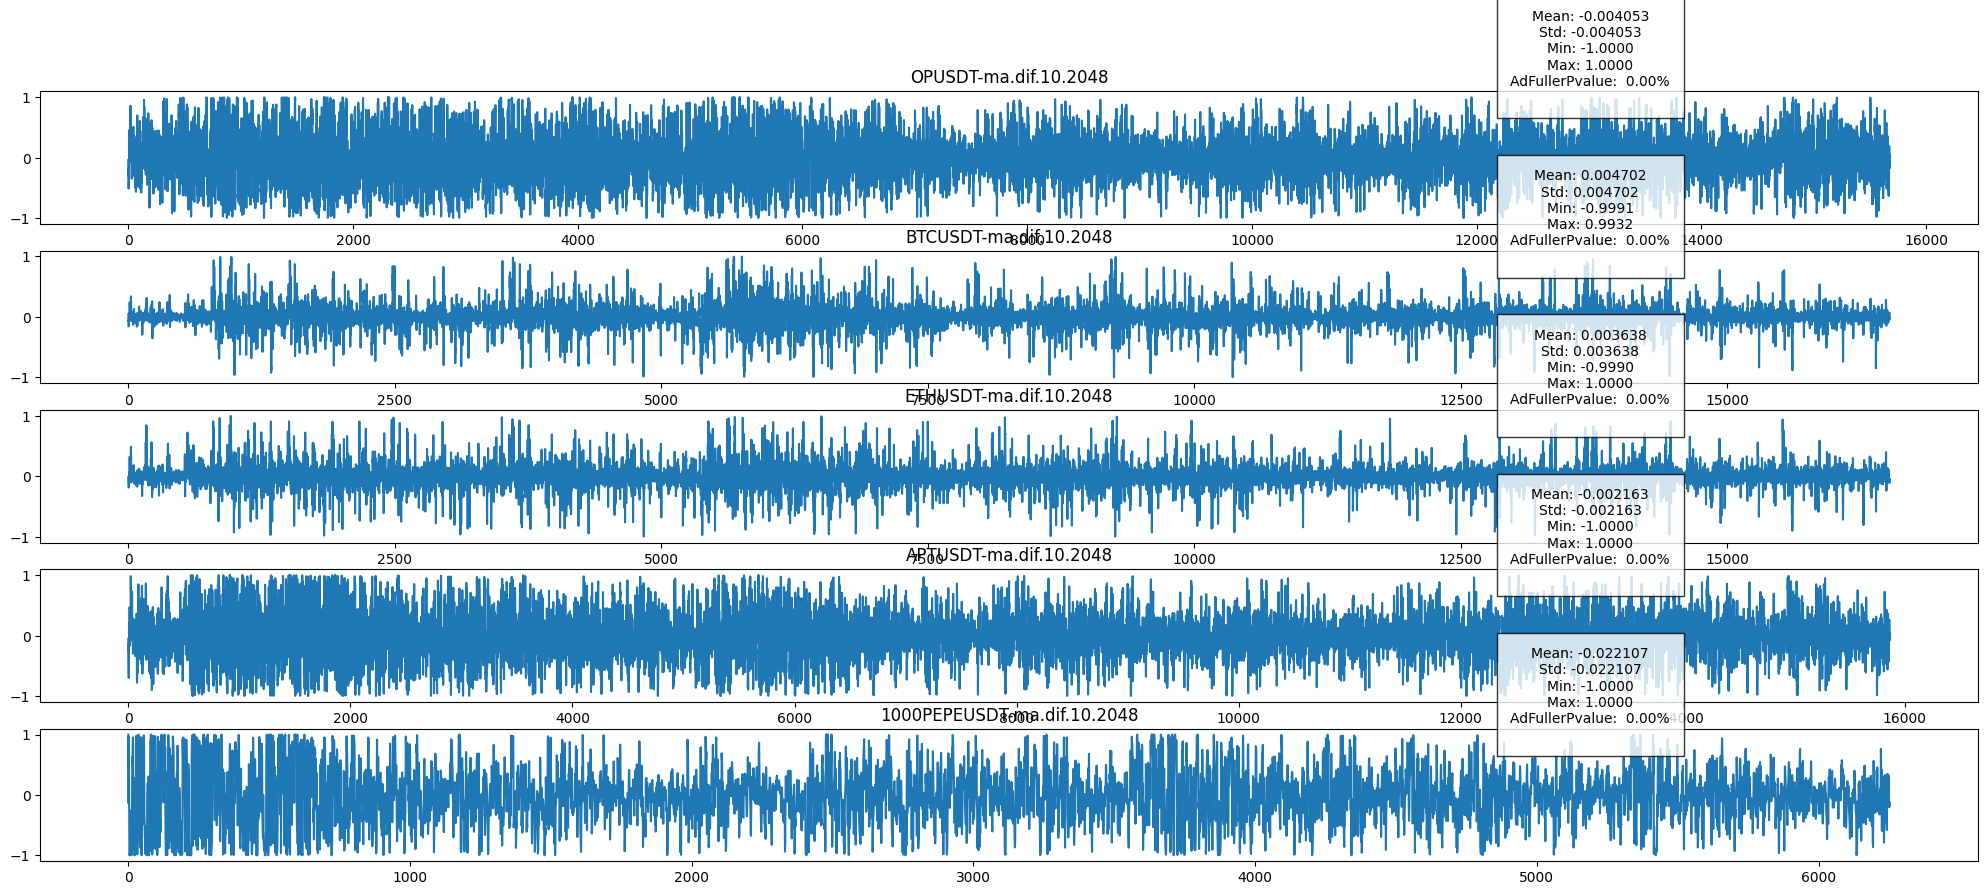

In [6]:
import statsmodels.tsa.stattools as ts
for period in periods:
    f, axes = plt.subplots(len(product_list), 1, figsize=(5 * len(product_list), 10))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        
        T = len(arr)

        arr = arr[np.arange(0, T, period)]
        axes[i].plot(arr)
        axes[i].set_title(product + "-" + signal_name)
        _, p_val, _, _, _ = ts.adfuller(arr, maxlag=int(pow(len(arr)-1,(1/3))), regression='ct', autolag=None)
        
        mean = np.nanmean(arr)
        std = np.nanmean(arr)
        min_val = np.nanmin(arr)
        max_val = np.nanmax(arr)
        summary_text = f"Mean: {mean:.6f}\nStd: {std:.6f}\nMin: {min_val:.4f}\nMax: {max_val:.4f}\nAdFullerPvalue: {p_val: .2%}\n"
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

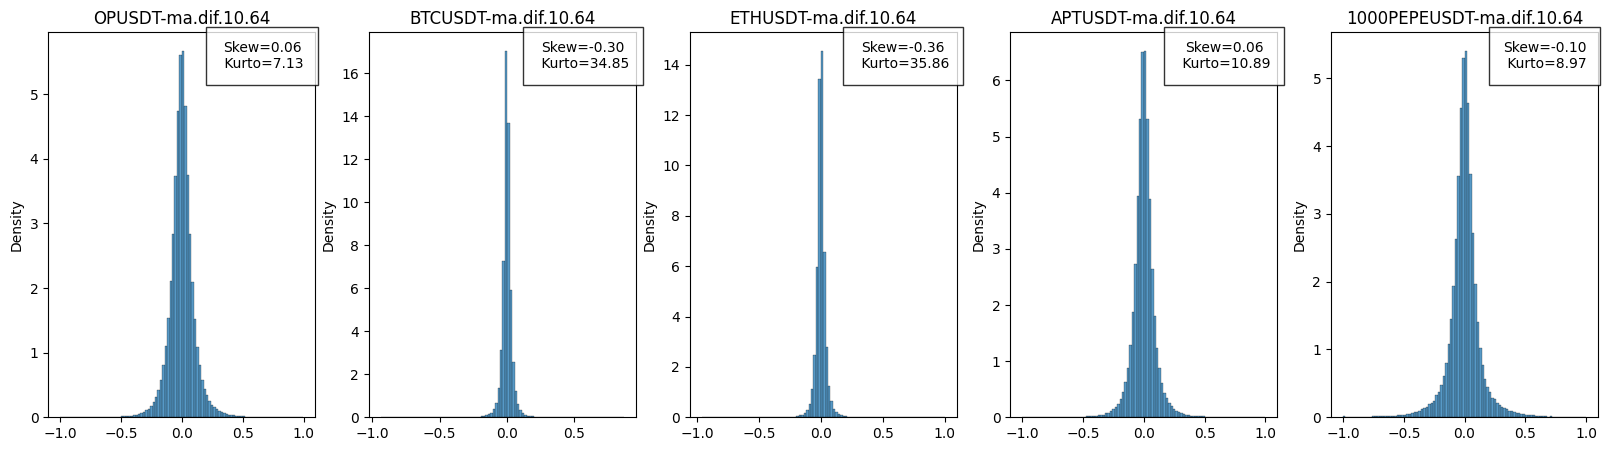

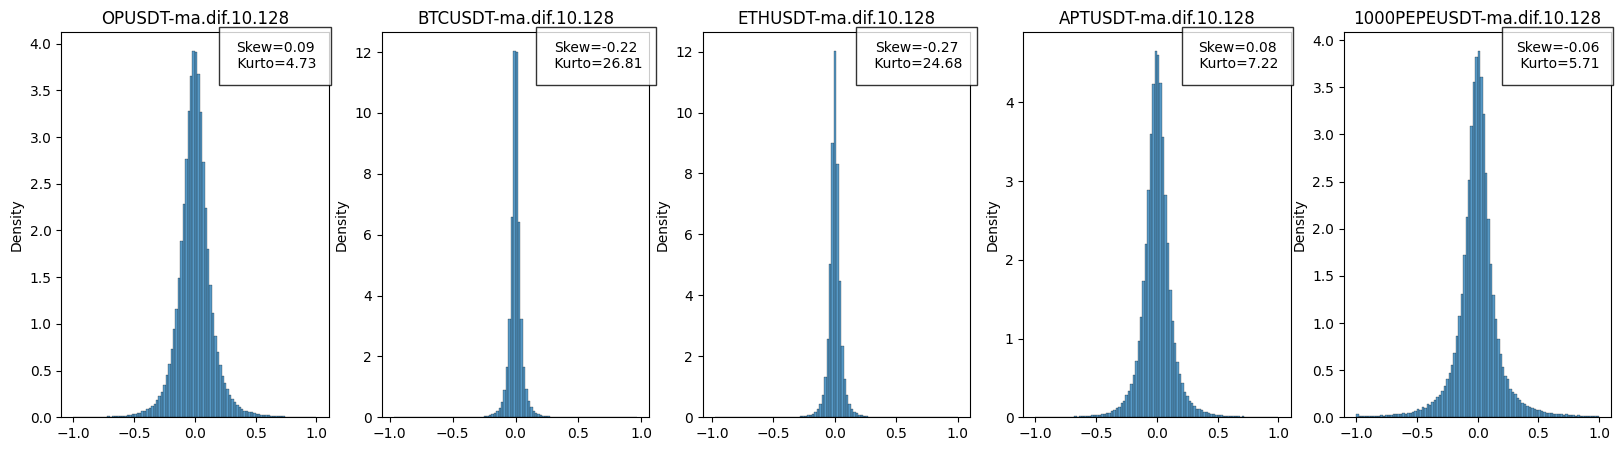

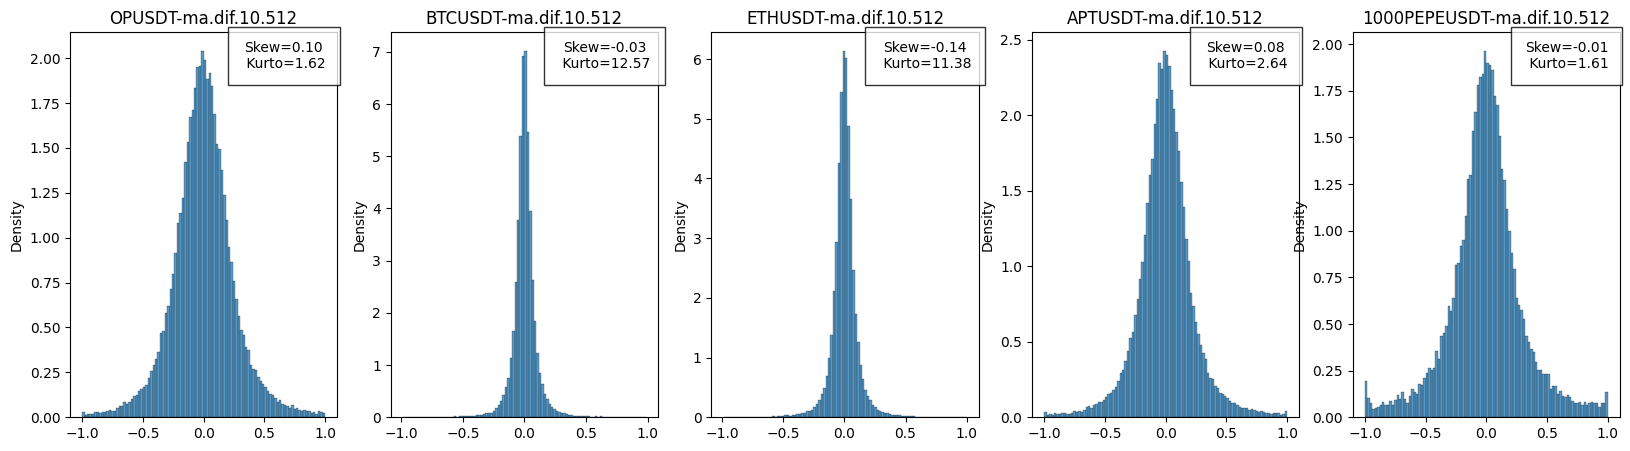

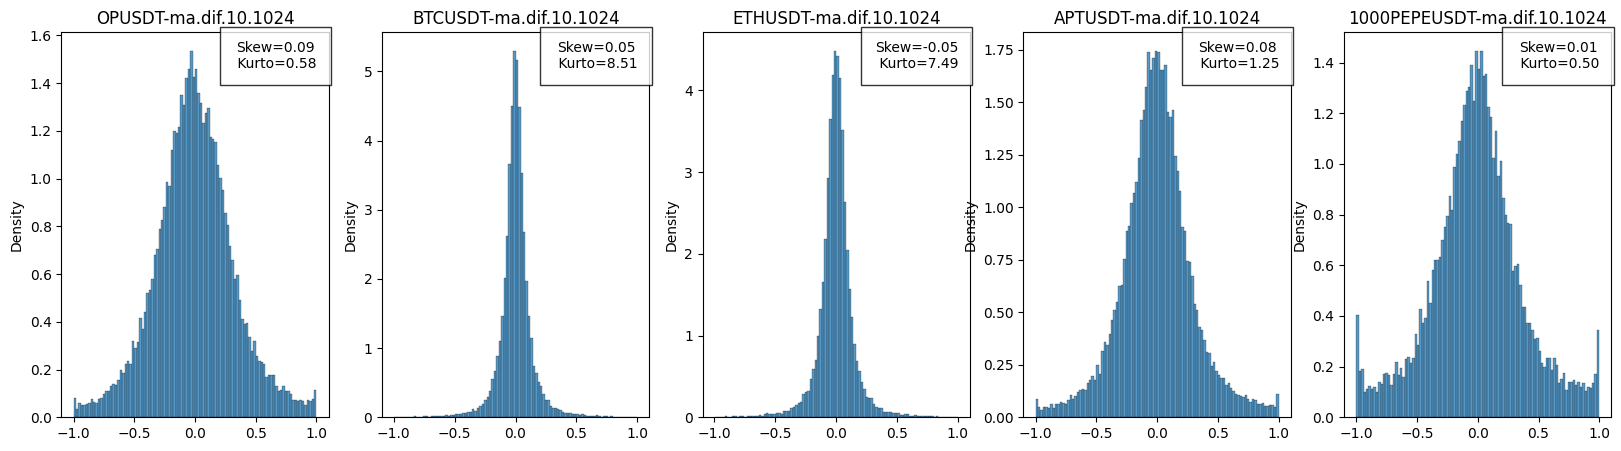

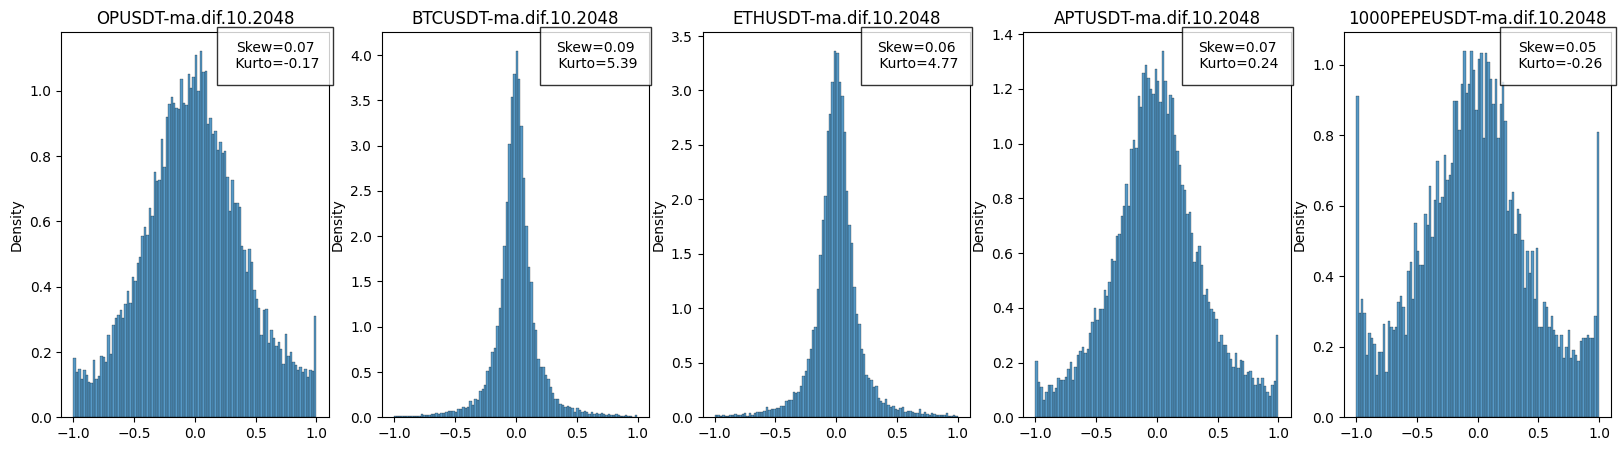

In [7]:
for period in periods:
    f, axes = plt.subplots(1, len(product_list), figsize=(20, 5))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        T = len(arr)
        arr = arr[np.arange(0, T, period)]
        skew = scipy.stats.skew(arr)
        kurto = scipy.stats.kurtosis(arr)
        summary_text = f"Skew={skew:.2f}\n Kurto={kurto:.2f}"
        # Plot the empirical histogram
        sns.histplot(arr, kde=False, bins=100, stat='density', label='Empirical', ax=axes[i])

        # # Fit a normal distribution to the data
        # mean, std = norm.fit(data)

        # # Generate values for the estimated normal distribution
        # x = np.linspace(min(data), max(data), 100)
        # y = norm.pdf(x, mean, std)

        # axes[i].plot(x, y, label='Estimated', color='red')
        axes[i].set_title(product + "-" + signal_name)
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

In [2]:
trades_signal_period = [signal_name_format.format(period=period) for period in periods]
results = factor_analysis.get_signal_performance_result(trades_signal_period, "signal_result_with_atr", product_list, 1e-4, 1)

trend_res = results['trend.signal.stat']
reve_res = results["reverse.signal.stat"]
signal_trend_res = trend_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']
signal_rever_res = reve_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']

trend_signals = signal_trend_res[(signal_trend_res - signal_rever_res) > 0].index
reverse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) < 0].index
nouse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) == 0].index

print("#trend={}, #reverse={}, #nouse={}".format(len(trend_signals), len(reverse_signals), len(nouse_signals)))

merge_res = pd.concat([trend_res.loc[np.isin(trend_res['signal'], trend_signals)], 
                       reve_res.loc[np.isin(reve_res['signal'], reverse_signals)]], 
                      axis=0)

display(merge_res.sort_values(by='trainSharpe', ascending=False))

#trend=5, #reverse=2, #nouse=0


signal  reverse  num_good_product  \
0    ma.dif.10.32  reverse                 4   
5  ma.dif.10.1024    trend                 2   
2   ma.dif.10.128  reverse                 5   
1    ma.dif.10.64  reverse                 4   
3   ma.dif.10.256  reverse                 4   
4   ma.dif.10.512  reverse                 4   
6  ma.dif.10.2048    trend                 4   

                                  good_product      good_product_sharpe  \
0          OPUSDT,BTCUSDT,ETHUSDT,1000PEPEUSDT      1.16,1.49,2.77,3.38   
5                         APTUSDT,1000PEPEUSDT                1.16,2.74   
2  OPUSDT,BTCUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT  1.15,2.09,2.5,2.41,1.28   
1          OPUSDT,BTCUSDT,ETHUSDT,1000PEPEUSDT       1.75,1.5,1.76,1.98   
3          OPUSDT,BTCUSDT,ETHUSDT,1000PEPEUSDT      0.49,1.33,1.71,1.35   
4          OPUSDT,BTCUSDT,ETHUSDT,1000PEPEUSDT      1.06,0.87,1.45,1.28   
6          OPUSDT,BTCUSDT,APTUSDT,1000PEPEUSDT        0.25,0.2,0.77,2.0   

   trainSharpe  testSharpe  trainSharpeV2  testSharpeV2  \
0     2.201486   -0.380338       1.161013     -0.940277   
5     1.950014    1.333542       1.159035      1.125652   
2     1.887921    1.092035       1.148013      0.574194   
1     1.747835    0.598218       1.745740     -0.555880   
3     1.219928    0.861833       0.488321      1.462300   
4     1.166182    1.151625       1.059196      1.232133   
6     0.802338   -0.496753       0.246436     -2.115629   

   trainAvgDailyTradeNum  testAvgDailyTradeNum  sum_good_strat  avgTrainRet  \
0              75.940629             26.909762              58     0.005863   
5              13.016429              6.586613              36     0.010486   
2              40.909035             14.473466              82     0.002769   
1              42.830881             15.072638              70     0.002948   
3              28.802129             10.499912              97     0.002229   
4              27.054323             11.491967              92     0.002681   
6              14.659084              7.713772              43     0.004240   

   avgTestRet  trainReturn  testReturn  
0   -0.001061     0.503504   -0.083929  
5    0.002663     0.624836    0.219783  
2    0.000925     0.470913    0.078187  
1    0.000416     0.381948    0.024191  
3    0.000649     0.341097    0.088806  
4    0.000962     0.396813    0.124934  
6   -0.000413     0.306540   -0.084945